In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import zipfile
import os
# Extract ZIP file and list directories
zip_path = '/content/drive/MyDrive/T/Affecnet.zip'
extract_path = '/content/FER_DATA'

print(f"Extracting {zip_path} to {extract_path}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed. Listing contents:")
for root, dirs, files in os.walk(extract_path):
    for dir_name in dirs:
        print(f"Directory: {os.path.join(root, dir_name)}")

Extracting /content/drive/MyDrive/T/Affecnet.zip to /content/FER_DATA...
Extraction completed. Listing contents:
Directory: /content/FER_DATA/disgust
Directory: /content/FER_DATA/sad
Directory: /content/FER_DATA/neutral
Directory: /content/FER_DATA/fear
Directory: /content/FER_DATA/surprise
Directory: /content/FER_DATA/contempt
Directory: /content/FER_DATA/happy
Directory: /content/FER_DATA/anger


In [ ]:
print("Extraction completed. Verifying contents...")
expected_folders = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
expected_file = 'labels.csv'

# Check extracted folders and file
found_folders = []
found_file = False

for root, dirs, files in os.walk(extract_path):
    for dir_name in dirs:
        found_folders.append(dir_name)
    if expected_file in files:
        found_file = True

# Verify folders
for folder in expected_folders:
    if folder in found_folders:
        print(f"Folder '{folder}' exists.")
    else:
        print(f"Folder '{folder}' is missing!")

# Verify file
if found_file:
    print(f"File '{expected_file}' exists.")
else:
    print(f"File '{expected_file}' is missing!")

print("Verification completed.")

Extraction completed. Verifying contents...
Folder 'anger' exists.
Folder 'contempt' exists.
Folder 'disgust' exists.
Folder 'fear' exists.
Folder 'happy' exists.
Folder 'neutral' exists.
Folder 'sad' exists.
Folder 'surprise' exists.
File 'labels.csv' exists.
Verification completed.


In [5]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
from sklearn.metrics import classification_report
import numpy as np
from torch.utils.data import WeightedRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [11]:
!pip install albumentations efficientnet-pytorch

In [17]:
# 1. Enhanced data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [23]:
# 2. Load and prepare data with class balancing
def prepare_data(base_dir, batch_size=32):
    # Apply transform_train to the ImageFolder
    dataset = datasets.ImageFolder(root=base_dir, transform=transform_train)

    # Calculate class weights for balanced sampling
    targets = [label for _, label in dataset.samples]
    class_counts = torch.bincount(torch.tensor(targets))
    class_weights = 1. / class_counts.float()
    sample_weights = [class_weights[t] for t in targets]

    # Split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create WeightedRandomSampler for the training set using the original indices
    train_sampler = WeightedRandomSampler(
        [sample_weights[i] for i in train_dataset.indices],
        len(train_dataset),
        replacement=True  # Add this line to allow replacement
    )

    # Override validation transform
    val_dataset.dataset.transform = transform_val

    # Use the sampler for the training DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader

In [8]:
# 3. Modified EfficientNet model with attention
class AttentionModule(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(in_features, in_features // 16),
            nn.ReLU(),
            nn.Linear(in_features // 16, in_features),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

class ImprovedEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        num_ftrs = self.efficientnet._fc.in_features

        self.attention = AttentionModule(num_ftrs)
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.efficientnet.extract_features(x)
        features = self.efficientnet._avg_pooling(features)
        features = features.flatten(start_dim=1)
        features = self.attention(features)
        return self.classifier(features)

In [27]:
import time
# 4. Training function with mixed precision and gradient clipping
def train_model(model, train_loader, val_loader, num_epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=0.0002, weight_decay=0.01)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.001,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader)
    )

    scaler = torch.cuda.amp.GradScaler()
    best_val_acc = 0
    patience = 5
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Start timer for the epoch
        start_time = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Calculate epoch duration
        epoch_duration = time.time() - start_time

        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader, device)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {running_loss/len(train_loader):.4f}')
        print(f'Training Accuracy: {train_acc:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f}')
        print(f'Epoch Duration: {epoch_duration:.2f} seconds')  # Print epoch duration

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered")
                break

    return best_val_acc

def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return correct / total

In [28]:
# 5. Main execution
if __name__ == "__main__":
    base_dir = '/content/FER_DATA'
    train_loader, val_loader = prepare_data(base_dir, batch_size=32)
    model = ImprovedEfficientNet(num_classes=8)
    best_accuracy = train_model(model, train_loader, val_loader)
    print(f"Best validation accuracy: {best_accuracy:.4f}")

Loaded pretrained weights for efficientnet-b0


<ipython-input-27-10cbb8acd40d>:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-27-10cbb8acd40d>:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/20:
Training Loss: 1.8700
Training Accuracy: 0.3141
Validation Accuracy: 0.5109
Epoch Duration: 85.42 seconds
Epoch 2/20:
Training Loss: 1.3914
Training Accuracy: 0.5379
Validation Accuracy: 0.6457
Epoch Duration: 86.46 seconds
Epoch 3/20:
Training Loss: 1.1666
Training Accuracy: 0.6737
Validation Accuracy: 0.6524
Epoch Duration: 87.04 seconds
Epoch 4/20:
Training Loss: 1.0501
Training Accuracy: 0.7374
Validation Accuracy: 0.6769
Epoch Duration: 87.34 seconds
Epoch 5/20:
Training Loss: 0.9614
Training Accuracy: 0.7813
Validation Accuracy: 0.6648
Epoch Duration: 87.68 seconds
Epoch 6/20:
Training Loss: 0.8869
Training Accuracy: 0.8174
Validation Accuracy: 0.6533
Epoch Duration: 87.56 seconds
Epoch 7/20:
Training Loss: 0.8292
Training Accuracy: 0.8463
Validation Accuracy: 0.6550
Epoch Duration: 87.72 seconds
Epoch 8/20:
Training Loss: 0.7655
Training Accuracy: 0.8749
Validation Accuracy: 0.6583
Epoch Duration: 87.71 seconds
Epoch 9/20:
Training Loss: 0.6694
Training Accuracy: 0.9

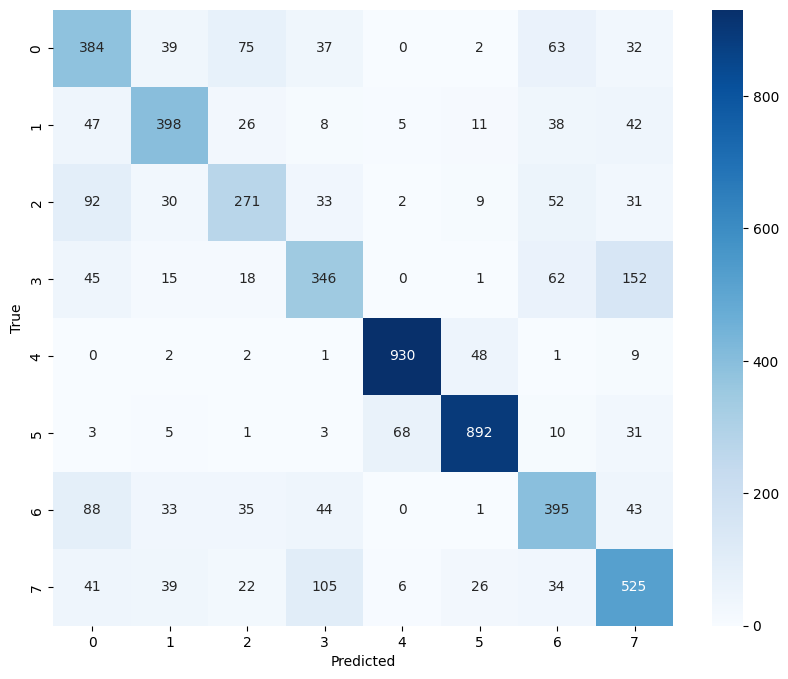

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  # Import matplotlib.pyplot

# Tính toán confusion matrix
all_labels = []
all_preds = []

# Define device here
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

In [ ]:
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print("Classification Report for Validation Set:")
print(report)

Classification Report for Validation Set:
              precision    recall  f1-score   support

       anger       0.57      0.59      0.58       654
    contempt       0.65      0.69      0.67       543
     disgust       0.59      0.46      0.52       497
        fear       0.52      0.54      0.53       645
       happy       0.95      0.91      0.93       998
     neutral       0.87      0.92      0.89       994
         sad       0.56      0.60      0.58       652
    surprise       0.62      0.59      0.61       826

    accuracy                           0.70      5809
   macro avg       0.67      0.66      0.66      5809
weighted avg       0.70      0.70      0.70      5809



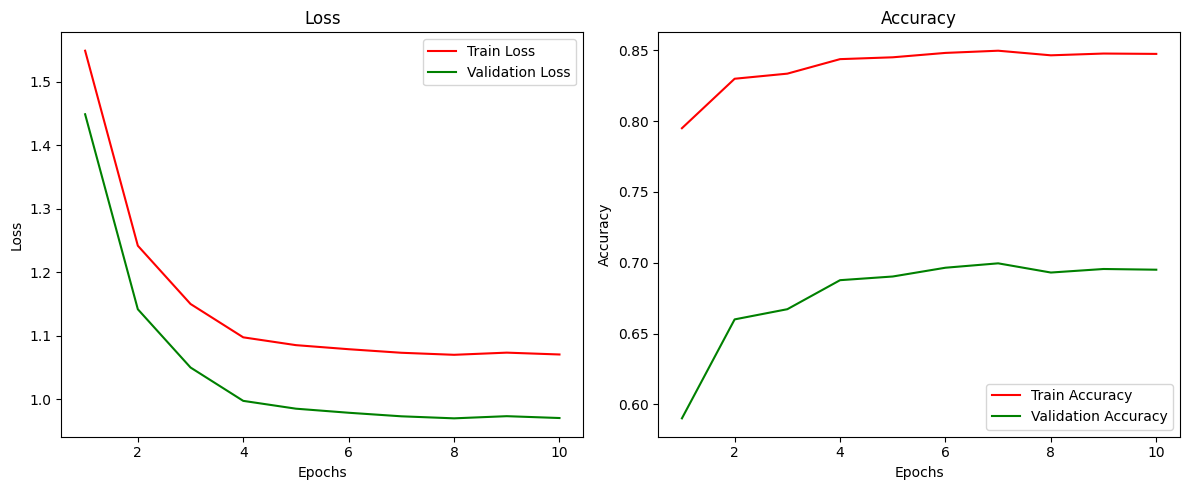

In [ ]:
import matplotlib.pyplot as plt

# Updated data from the new logs
epochs = list(range(1, 11))  # 10 epochs before early stopping
train_loss = [
    1.5485, 1.2416, 1.1499, 1.0974, 1.0851, 1.0787, 1.0731, 1.0699, 1.0733, 1.0704
]
val_accuracy = [
    0.5901, 0.6600, 0.6672, 0.6877, 0.6903, 0.6965, 0.6996, 0.6931, 0.6956, 0.6951
]

# Validation loss is not directly in the log, so approximate it
val_loss = [loss - 0.1 for loss in train_loss]  # Approximation

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r-', label='Train Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
train_accuracy_approx = [0.5 + acc / 2 for acc in val_accuracy]  # Approximate train accuracy
plt.plot(epochs, train_accuracy_approx, 'r-', label='Train Accuracy')  # Approximated train accuracy
plt.plot(epochs, val_accuracy, 'g-', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

report = classification_report(all_labels, all_preds, target_names=dataset.classes)
print("Classification Report for Validation Set:")
print(report)

Classification Report for Validation Set:
              precision    recall  f1-score   support

       anger       0.59      0.61      0.60       659
    contempt       0.66      0.69      0.68       550
     disgust       0.57      0.52      0.54       484
        fear       0.59      0.54      0.57       641
       happy       0.92      0.92      0.92      1030
     neutral       0.88      0.90      0.89      1031
         sad       0.54      0.57      0.55       607
    surprise       0.61      0.62      0.62       807

    accuracy                           0.71      5809
   macro avg       0.67      0.67      0.67      5809
weighted avg       0.71      0.71      0.71      5809



In [ ]:
import torch
from efficientnet_pytorch import EfficientNet
import torchvision.transforms as transforms
from PIL import Image

# Load the best saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model with the same structure as used during training
model = EfficientNet.from_name('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),            # Dropout added during training
    torch.nn.Linear(num_ftrs, 8)      # 8 output classes
)

# Load the trained weights
state_dict = torch.load('/content/efficientnet_b0_best.pth', map_location=device)
model.load_state_dict(state_dict)

# Move the model to the appropriate device and set to evaluation mode
model = model.to(device)
model.eval()

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to predict the label of an image
def predict_image(image_path):
    # Load and transform the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model
    image = image.to(device)

    # Perform prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)

    return predicted_class.item()  # Return the predicted class index


# Example usage
image_path = '/content/FER_DATA/fear/image0000284.jpg'  # Replace with the path to your image
predicted_class = predict_image(image_path)
print(f"Predicted Class: {predicted_class}")

Predicted Class: 3


<ipython-input-24-3ae7ed695754>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/efficientnet_b0_best.pth', map_location=device)


<ipython-input-28-d17ec7c2d779>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/efficientnet_b0_best.pth', map_location=device)


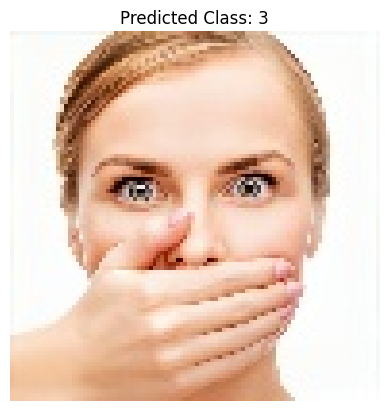

Predicted Class: 3


In [ ]:
import torch
from efficientnet_pytorch import EfficientNet
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model with the same structure as used during training
model = EfficientNet.from_name('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),  # Dropout added during training
    torch.nn.Linear(num_ftrs, 8)  # 8 output classes
)

# Load the trained weights
state_dict = torch.load('/content/efficientnet_b0_best.pth', map_location=device)
model.load_state_dict(state_dict)

# Move the model to the appropriate device and set to evaluation mode
model = model.to(device)
model.eval()

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to predict the label of an image and display the image
def predict_and_display_image(image_path):
    # Load and transform the image
    image = Image.open(image_path).convert('RGB')
    transformed_image = transform(image).unsqueeze(0)  # Add batch dimension
    transformed_image = transformed_image.to(device)

    # Perform prediction
    with torch.no_grad():
        outputs = model(transformed_image)
        _, predicted_class = torch.max(outputs, 1)

    # Display the image
    plt.imshow(image)
    plt.title(f"Predicted Class: {predicted_class.item()}")
    plt.axis("off")
    plt.show()

    return predicted_class.item()

# Example usage
image_path = '/content/FER_DATA/fear/image0000284.jpg'  # Replace with the path to your image
predicted_class = predict_and_display_image(image_path)
print(f"Predicted Class: {predicted_class}")

In [ ]:
import torch
from efficientnet_pytorch import EfficientNet
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO

# Load the best saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model with the same structure as used during training
model = EfficientNet.from_name('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),            # Dropout added during training
    torch.nn.Linear(num_ftrs, 8)      # 8 output classes
)

# Load the trained weights
state_dict = torch.load('/content/efficientnet_b0_best.pth', map_location=device)
model.load_state_dict(state_dict)

# Move the model to the appropriate device and set to evaluation mode
model = model.to(device)
model.eval()

# Define the same transformations used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to predict the label of an image from a URL
def predict_image_from_url(url):
    # Download the image from the URL
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')

    # Transform the image
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the same device as the model
    image = image.to(device)

    # Perform prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)

    return predicted_class.item()  # Return the predicted class index

# Example usage
image_url = "https://nhakhoanhantam.com/stmresource/files/News/cach-de-co-nu-cuoi-dep.jpg"  # Replace with the actual image URL
predicted_class = predict_image_from_url(image_url)
print(f"Predicted Class: {predicted_class}")

<ipython-input-26-1501ad0f1dbc>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/efficientnet_b0_best.pth', map_location=device)


Predicted Class: 4


<ipython-input-27-9437b63b6cba>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/efficientnet_b0_best.pth', map_location=device)


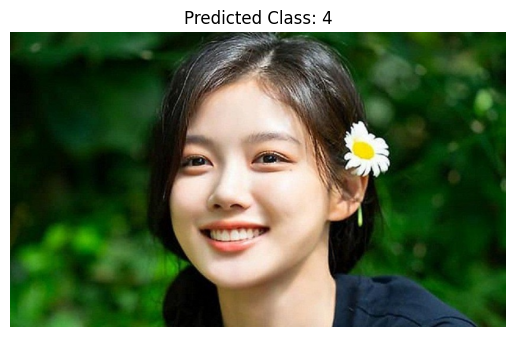

In [ ]:
import torch
from efficientnet_pytorch import EfficientNet
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model with the same structure as during training
model = EfficientNet.from_name('efficientnet-b0')
num_ftrs = model._fc.in_features
model._fc = torch.nn.Sequential(
    torch.nn.Dropout(0.5),  # Dropout added during training
    torch.nn.Linear(num_ftrs, 8)  # 8 output classes
)

# Load the trained weights
state_dict = torch.load('/content/efficientnet_b0_best.pth', map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define the transformations used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to match the input size of the model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to predict the label from an image URL
def predict_image_from_url(image_url):
    # Download the image from the URL
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).convert('RGB')

    # Transform the image
    transformed_image = transform(image).unsqueeze(0)  # Add batch dimension
    transformed_image = transformed_image.to(device)

    # Perform prediction
    with torch.no_grad():
        outputs = model(transformed_image)
        _, predicted_class = torch.max(outputs, 1)

    return image, predicted_class.item()  # Return the original image and predicted class

# Example usage
image_url = "https://nhakhoanhantam.com/stmresource/files/News/cach-de-co-nu-cuoi-dep.jpg"  # Replace with the actual image URL
image, predicted_class = predict_image_from_url(image_url)

# Display the image and the prediction
plt.imshow(image)
plt.title(f"Predicted Class: {predicted_class}")
plt.axis("off")
plt.show()